# Transfer Learning with ResNet50 to detect HLB


Transfer learning employing the database of leaves with and without HLB without the mask

Accessing to Google Drive and importing the libraries

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

Time_start = datetime.now()
print("\n Start time:", Time_start)

# !pip install tensorflow
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory


#tf.compat.v1.disable_eager_execution()
#from keras.applications.vgg16 import VGG16
#from keras import backend as K
#import tensorflow.keras.backend as K

#from keras.applications.vgg16 import preprocess_input

#from keras.applications.vgg16 import decode_predictions
#K.clear_session()


 Start time: 2024-11-11 01:19:36.550033


Directories that are going to be used and number of elements by class in training and validation

In [ ]:
ModelFolder = ('/content/drive/MyDrive/Research/HLB Classification/Arquitecturas/ResNet50')
ImagesFolder = ('/content/drive/MyDrive/Research/HLB Classification/Database')
ImagesSplittedFolder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted')

Training_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/train')
Validation_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/val')



SubFolders_Training = os.listdir(Training_Folder)
print("Training images by category:")

for iSubFolder in range(len(SubFolders_Training)):
  CurrentFolder = os.path.join(Training_Folder, SubFolders_Training[iSubFolder])
  print(SubFolders_Training[iSubFolder], len(os.listdir(CurrentFolder)))

SubFolders_Validation = os.listdir(Validation_Folder)
print("\nValidation images by category:")

for iSubFolder in range(len(SubFolders_Validation)):
  CurrentFolder = os.path.join(Validation_Folder, SubFolders_Validation[iSubFolder])
  print(SubFolders_Validation[iSubFolder], len(os.listdir(CurrentFolder)))


Training images by category:
1 HLB 349
0 Sanas 273

Validation images by category:
1 HLB 88
0 Sanas 69


Definition of the training and validation datasets with the characteristics of the neural network

In [ ]:
Batch_Size = 32
Img_Size = (224, 224)

Train_Dataset = image_dataset_from_directory(Training_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Validation_Dataset_Original = image_dataset_from_directory(Validation_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Found 622 files belonging to 2 classes.
Found 157 files belonging to 2 classes.


Verify the first 9 images and labels of the dataset

In [ ]:
sorted(os.listdir(Training_Folder))

['0 Sanas', '1 HLB']

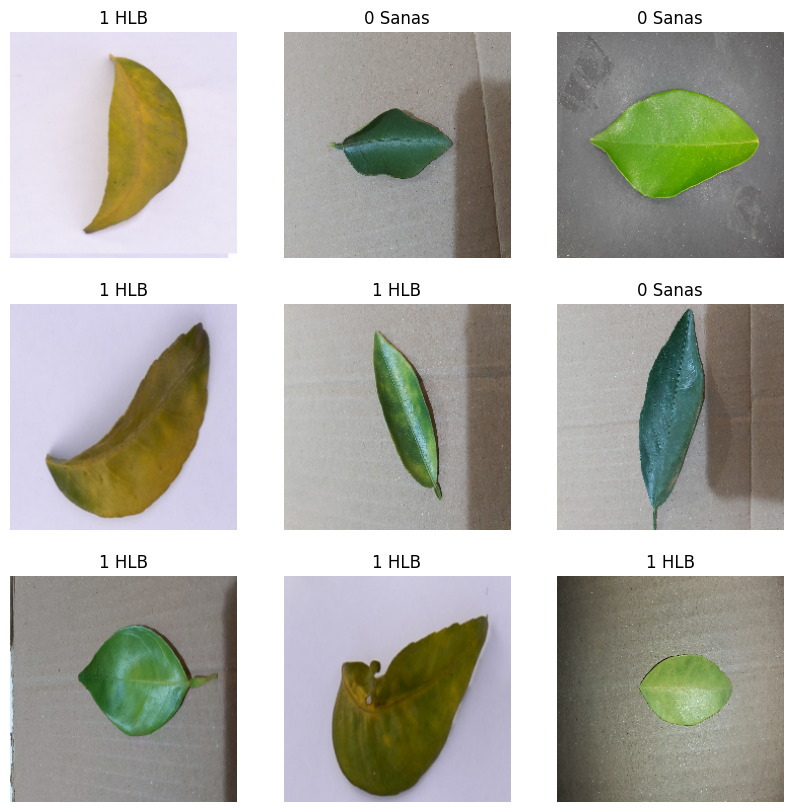

In [ ]:
class_names = Train_Dataset.class_names

class_names = Train_Dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in Train_Dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig(os.path.join(ModelFolder, '01 01 Imagenes Prueba.jpg'))


A test dataset is created.

Determine the validation dataset employing a lot of data batches *tf.data.experimental.cardinality*



In [ ]:
val_batches = tf.data.experimental.cardinality(Validation_Dataset_Original)
test_dataset = Validation_Dataset_Original.take(val_batches // 5)
Validation_Dataset = Validation_Dataset_Original.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(Validation_Dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [ ]:
Autotune = tf.data.AUTOTUNE

Train_Dataset = Train_Dataset.prefetch(buffer_size=Autotune)
Validation_Dataset = Validation_Dataset.prefetch(buffer_size=Autotune)
test_dataset = test_dataset.prefetch(buffer_size=Autotune)

Data augmented

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation([0, 0.99]),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.RandomZoom(height_factor = [-0.4, 0.4], width_factor=[-0.4, 0.4])])

Showing the augmented data

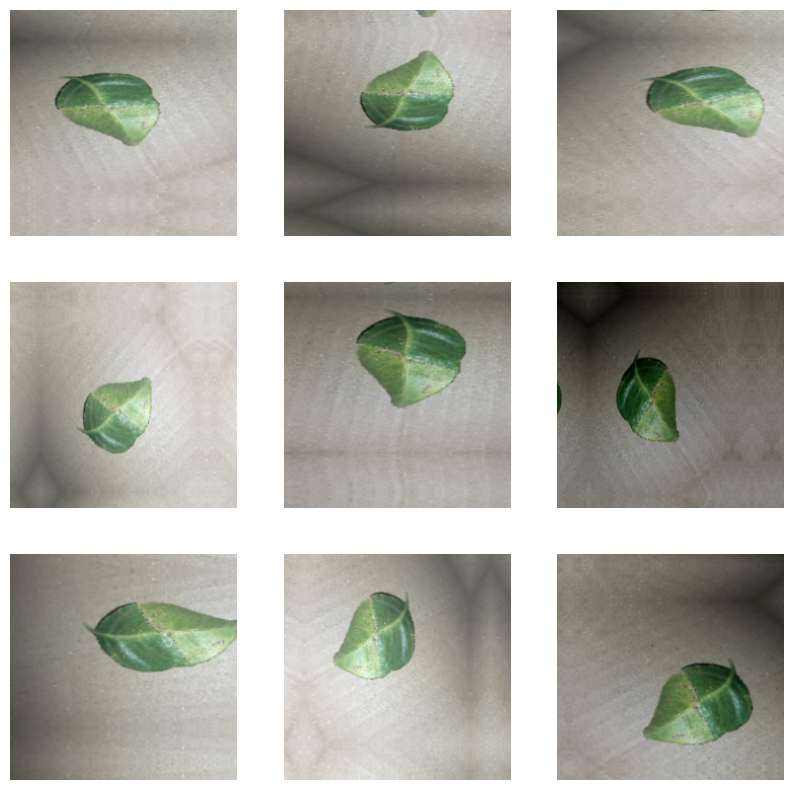

In [ ]:
for image, _ in Train_Dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.savefig(os.path.join(ModelFolder, '01 02 Augmented Images.jpg'))

Changing the **scale of the pixels values to use ResNet18**

They should be between [-1 and 1], at this momment, they are between [0, 255]


In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

#rescale = tf.keras.Sequential([layers.Rescaling(1./127.5, offset= -1)])
from tensorflow.keras import layers

rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

The *bottle neeck layer* is employed to preserve the characteristics with more generalities in comparition with the final layer of the MobilNet model.

The model is employed with the weights trained in ImageNet, when *include_top = false* as argument, the classification layers are not chaarged in the model

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
Img_Shape = Img_Size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape = Img_Shape,
                                               include_top = False,
                                               weights = 'imagenet')
image_batch, label_batch = next(iter(Train_Dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 2048)


Feature extraction

Convolutional base created is frozen and used as a feature extractor. A classification is added at the top and trains the classificatior at the superior level (last layers).

Frozen of the convolutional base is realized with *layer.trainable = False* avoiding that the weights of a specific layer get refreshed during the training.


In [ ]:
base_model.trainable = False


**Special note about *BatchNormalization* layers**

A lot of models contains *tf.keras.layers.BatchNormalization*, this is  special case and special warnings should be takenat fine tuning.

When *layer.trainable = False* is employed, BatchNormalization layers is going to execute as inference mode and is not going to refresh the average and variance statistics.

When a model with BatchNormalization layers is unfrozen to make a fine tuning, it should keep the BatchNormalization layers in inference employing *training = False* when is called the base model.

If this is not realized, the refresh applied to non trainable weights will destroy the learned by the model.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

**Add a clasification header**


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a *tf.keras.layers.Dense*  to convert characteristics in one single prediction per image.
An activation layer is not necessary here because this prediction will be treated as a logit or a prime prediction.

**Positive numbers predict the class 1, while negative numbers precict the class 0.**

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build the chain model with the data augmented, scale change, *base_model* layers and extracting the characteristics employing the functional API Keras.

As previosly where mentioned, use *training = False* because our model has a BarchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile the model**

Compile the model before trained. A binary lost cross entropy is employed with *from_logits = True* because we have two clases and a lineal output.

In [ ]:
base_learning_rate = 0.0001
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#model.compile(keras.optimizers.SGD(), loss='mse') # CHECK IF LOSS 'mse' IS AN OPTION
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,049 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
len(model.trainable_variables)

2

**Training the model**

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(Validation_Dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(Train_Dataset,
                    epochs=initial_epochs,
                    callbacks=[callback],
                    validation_data=Validation_Dataset_Original)



4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 806ms/step - accuracy: 0.5367 - loss: 0.7111
initial loss: 0.73
initial accuracy: 0.47
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5009 - loss: 0.7450 - val_accuracy: 0.6242 - val_loss: 0.6870
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5626 - loss: 0.6984 - val_accuracy: 0.6688 - val_loss: 0.6409
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6043 - loss: 0.6615 - val_accuracy: 0.6879 - val_loss: 0.5989
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5670 - loss: 0.6693 - val_accuracy: 0.7070 - val_loss: 0.5658
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6448 - loss: 0.6165 - val_accuracy: 0.7261 - val_loss: 0.5409
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6897 - loss: 0.5812 - val_accuracy: 0.7134 - val_loss: 0.5197
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6994 - loss: 0.5660 - val_accuracy: 0.7197 - val_loss: 0.5008
Epo

In [ ]:
# First Training Time
First_Training = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print('\n Duration: {}'.format(First_Training - Time_start))


 Start time: 2024-11-11 01:19:36.550033

 End time of the first training: 2024-11-11 01:26:41.969162

 Duration: 0:07:05.419129


**Learning Curves**

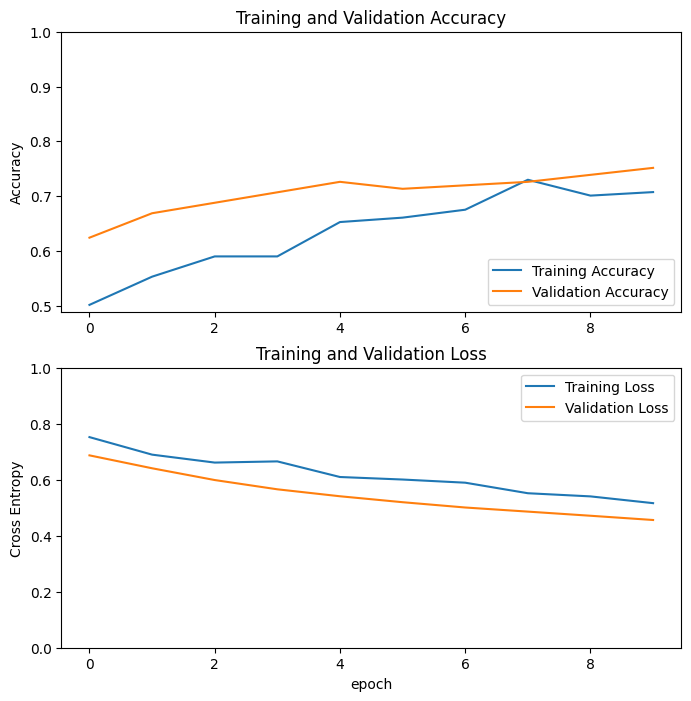

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig(os.path.join(ModelFolder, '01 03 Training and Validation Accuracy.jpg'))


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(ModelFolder, '01 03 Learning Curves.jpg'))
plt.show()


In [ ]:
os.chdir(ModelFolder)
model.save('01_ResNet50_NoFineTuning.keras')

# Fine Tuning

We are going to tune:

*   Learning rate
*   No. of epochs

We are going to unfreeze top layers of the model



In [ ]:
# Setting the top layers as trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# This step improves the accuracy of the model by a few steps
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#              metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

#model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])

Number of layers in the base model:  175


Compile the model

In [ ]:
model.summary()

len(model.trainable_variables)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,049 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 19,454,977 (74.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

92

Continue with the training model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(Train_Dataset,
                         epochs=total_epochs,
                         callbacks=[callback],
                         initial_epoch=history.epoch[-1],
                         validation_data=Validation_Dataset_Original)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7376 - loss: 0.5008 - val_accuracy: 0.8089 - val_loss: 0.3708
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7566 - loss: 0.4361 - val_accuracy: 0.8599 - val_loss: 0.3010
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8447 - loss: 0.3390 - val_accuracy: 0.9045 - val_loss: 0.2476
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9060 - loss: 0.2793 - val_accuracy: 0.9172 - val_loss: 0.2096
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8937 - loss: 0.2383 - val_accuracy: 0.9236 - val_loss: 0.1785
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9251 - loss: 0.1822 - val_accuracy: 0.9299 - val_loss: 0.1570
Epoch 16/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9323 - loss: 0.1846 - val_accuracy: 0.9299 - val_loss: 0.1390
Epoch 17/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9579 - loss: 0.1453 - val_accuracy: 0.9427 - v

In [ ]:
# Fine Tuning Training Time
Fine_Tuning_Time = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print("\n End time of the fine tuning training:", Fine_Tuning_Time)
print('\n Duration of the fine tuning training: {}'.format(Fine_Tuning_Time - First_Training))


 Start time: 2024-11-11 01:19:36.550033

 End time of the first training: 2024-11-11 01:26:41.969162

 End time of the fine tuning training: 2024-11-11 01:50:44.430596

 Duration of the fine tuning training: 0:24:02.461434


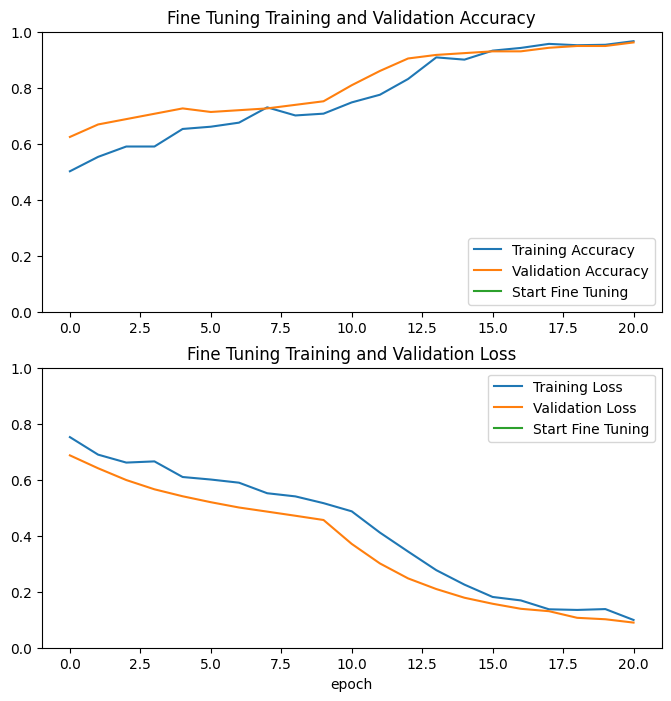

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(),  color = 'red',
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Fine Tuning Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(), color = 'red',
         label='Start Fine Tuning') # CHANGE COLOR TO RED OR SOMETHING
plt.legend(loc='upper right')
plt.title('Fine Tuning Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(ModelFolder, '01 04 Learning Curves Fine Tuning.jpg'))
plt.show()

In [ ]:
model.save('01_ResNet50_FineTuning.keras')